In [25]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [26]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [27]:
PPrint.register(repl)

In [28]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [29]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [30]:
val countriesSmooth = {
    val csvReader = CSVReader.open(new File("data/smooth_countries.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesSmooth: List[Map[String, String]] = List(
  Map("country" -> "Austria", "date" -> "2020-03-09", "cases" -> "27"),
  Map("country" -> "Austria", "date" -> "2020-03-10", "cases" -> "39"),
  Map("country" -> "Austria", "date" -> "2020-03-11", "cases" -> "56"),
  Map("country" -> "Austria", "date" -> "2020-03-12", "cases" -> "79"),
  Map("country" -> "Austria", "date" -> "2020-03-13", "cases" -> "107"),
  Map("country" -> "Austria", "date" -> "2020-03-14", "cases" -> "131"),
  Map("country" -> "Austria", "date" -> "2020-03-15", "cases" -> "161"),
  Map("country" -> "Austria", "date" -> "2020-03-16", "cases" -> "193"),
  Map("country" -> "Austria", "date" -> "2020-03-17", "cases" -> "243"),
  Map("country" -> "Austria", "date" -> "2020-03-18", "cases" -> "299"),
  Map("country" -> "Austria", "date" -> "2020-03-19", "cases" -> "354"),
  Map("country" -> "Austria", "date" -> "2020-03-20", "cases" -> "409"),
  Map("country" -> "Austria", "date" -> "2020-03-21", "cases" -> "477"),
  Ma

In [31]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-15",
    "Onset" -> "5.621968962172648"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-16",
    "Onset" -> "6.259456838021339"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-17",
    "Onset" -> "7.192531522793405"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-18",
    "Onset" -> "8.328806983511154"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-19",
    "Onset" -> "10.227934044616877"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-20",
    "Onset" -> "11.687681862269642"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-21",
    "Onset" -> "13.417070805043647"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-22",
...

In [32]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.006547041707080504"),
  Map("index" -> "1", "pdelay" -> "0.04194956353055286"),
  Map("index" -> "2", "pdelay" -> "0.05771096023278371"),
  Map("index" -> "3", "pdelay" -> "0.06983511154219205"),
  Map("index" -> "4", "pdelay" -> "0.07153249272550921"),
  Map("index" -> "5", "pdelay" -> "0.08583899127061105"),
  Map("index" -> "6", "pdelay" -> "0.07953443258971872"),
  Map("index" -> "7", "pdelay" -> "0.07516973811833172"),
  Map("index" -> "8", "pdelay" -> "0.07710960232783705"),
  Map("index" -> "9", "pdelay" -> "0.07904946653734239"),
  Map("index" -> "10", "pdelay" -> "0.06304558680892337"),
  Map("index" -> "11", "pdelay" -> "0.0511639185257032"),
  Map("index" -> "12", "pdelay" -> "0.04485935984481086"),
  Map("index" -> "13", "pdelay" -> "0.038554801163918524"),
  Map("index" -> "14", "pdelay" -> "0.028855480116391854"),
  Map("index" -> "15", "pdelay" -> "0.026430649854510185"),
  Map("index" -> 

In [33]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }
val cumulative_pdelay = pdelay.scanLeft(0.0)((x: Double, y: Double) => x+y).drop(1)

pdelay: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,
  9.699321047526673E-4,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
  0.001454898157129001,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
...
cumulative_pdelay: List[Double] = List(
  0.006547041707080504,
  0.0484966052

In [34]:
def prepareDataForModel(xs: List[Long]): List[((Int, Long), Long)] = {
    val adjacentPairs = xs.drop(1).zip(xs.take(xs.size - 1))
    adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
        (i, kt_prev) -> kt
    }
}

defined function prepareDataForModel

Preparation of the other model

In [35]:
import scala.collection.mutable.ListBuffer

def prepareDataForModelOnset(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    xs.map(_+1).zip(cpdPadded)
}

import scala.collection.mutable.ListBuffer


defined function prepareDataForModelOnset

In [36]:
val L = (1L to 100L).toList
val pd = pdelay
val test = prepareDataForModelOnset(L.takeRight(5), pd)

L: List[Long] = List(
  1L,
  2L,
  3L,
  4L,
  5L,
  6L,
  7L,
  8L,
  9L,
  10L,
  11L,
  12L,
  13L,
  14L,
  15L,
  16L,
  17L,
  18L,
  19L,
  20L,
  21L,
  22L,
  23L,
  24L,
  25L,
  26L,
  27L,
  28L,
  29L,
  30L,
  31L,
  32L,
  33L,
  34L,
  35L,
  36L,
  37L,
  38L,
...
pd: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,

In [37]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd36$Helper$$anon$1@1a97af9b

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [38]:
def retry[T](maxAttempts: Int, isSuccessful: T => Boolean)(f: => T): T = {
    var i = 0
    
    do {
        val res = f
        i = i + 1
        if (isSuccessful(res))
            return res
        println(s"WARN: Attempt[$i] failed. Retrying...")
    } while (i < maxAttempts)
    sys.error("Exceeded maximum number of retries")
}

defined function retry

Fixed the parameters for all distributions

In [39]:
def predictRt(caseNumbers: List[Long]): (Vec[Real], List[Seq[Double]]) = {
    val data = prepareDataForModel(caseNumbers)
    
    val (model, rts) =  {
        val (xs, ys) = data.unzip

        val serialInterval = Normal(5,2).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
            val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
            Poisson(lambda)
        }

        (Model.observe(ys, likelihoods), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRt

In [40]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [17]:

def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
    val data = prepareDataForModelOnset(onsetNumbers, pdelay)
    
    val (model, rts) =  {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1.5).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
            Poisson(lambda)
        }
        (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRtOnsetLogProcess

In [41]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb
def predictRtOnset(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): RtModelEstimates = {
    
    val data = prepareDataForModelOnset(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1/1.5).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest * cpd * (ThetaT(i).exp)
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        !failedRunDetection || trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
}

defined function predictRtOnset

In [42]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

Chain 1 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.86 E-BFMI: 0.75 Step size: 0.004 Total gradient evaluations: 2e+05 (52us) Total time: 20s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.86 E-BFMI: 0.53 Step size: 0.004 Total gradient evaluations: 2e+05 (49us) Total time: 20s

Elapsed time: 41284 ms


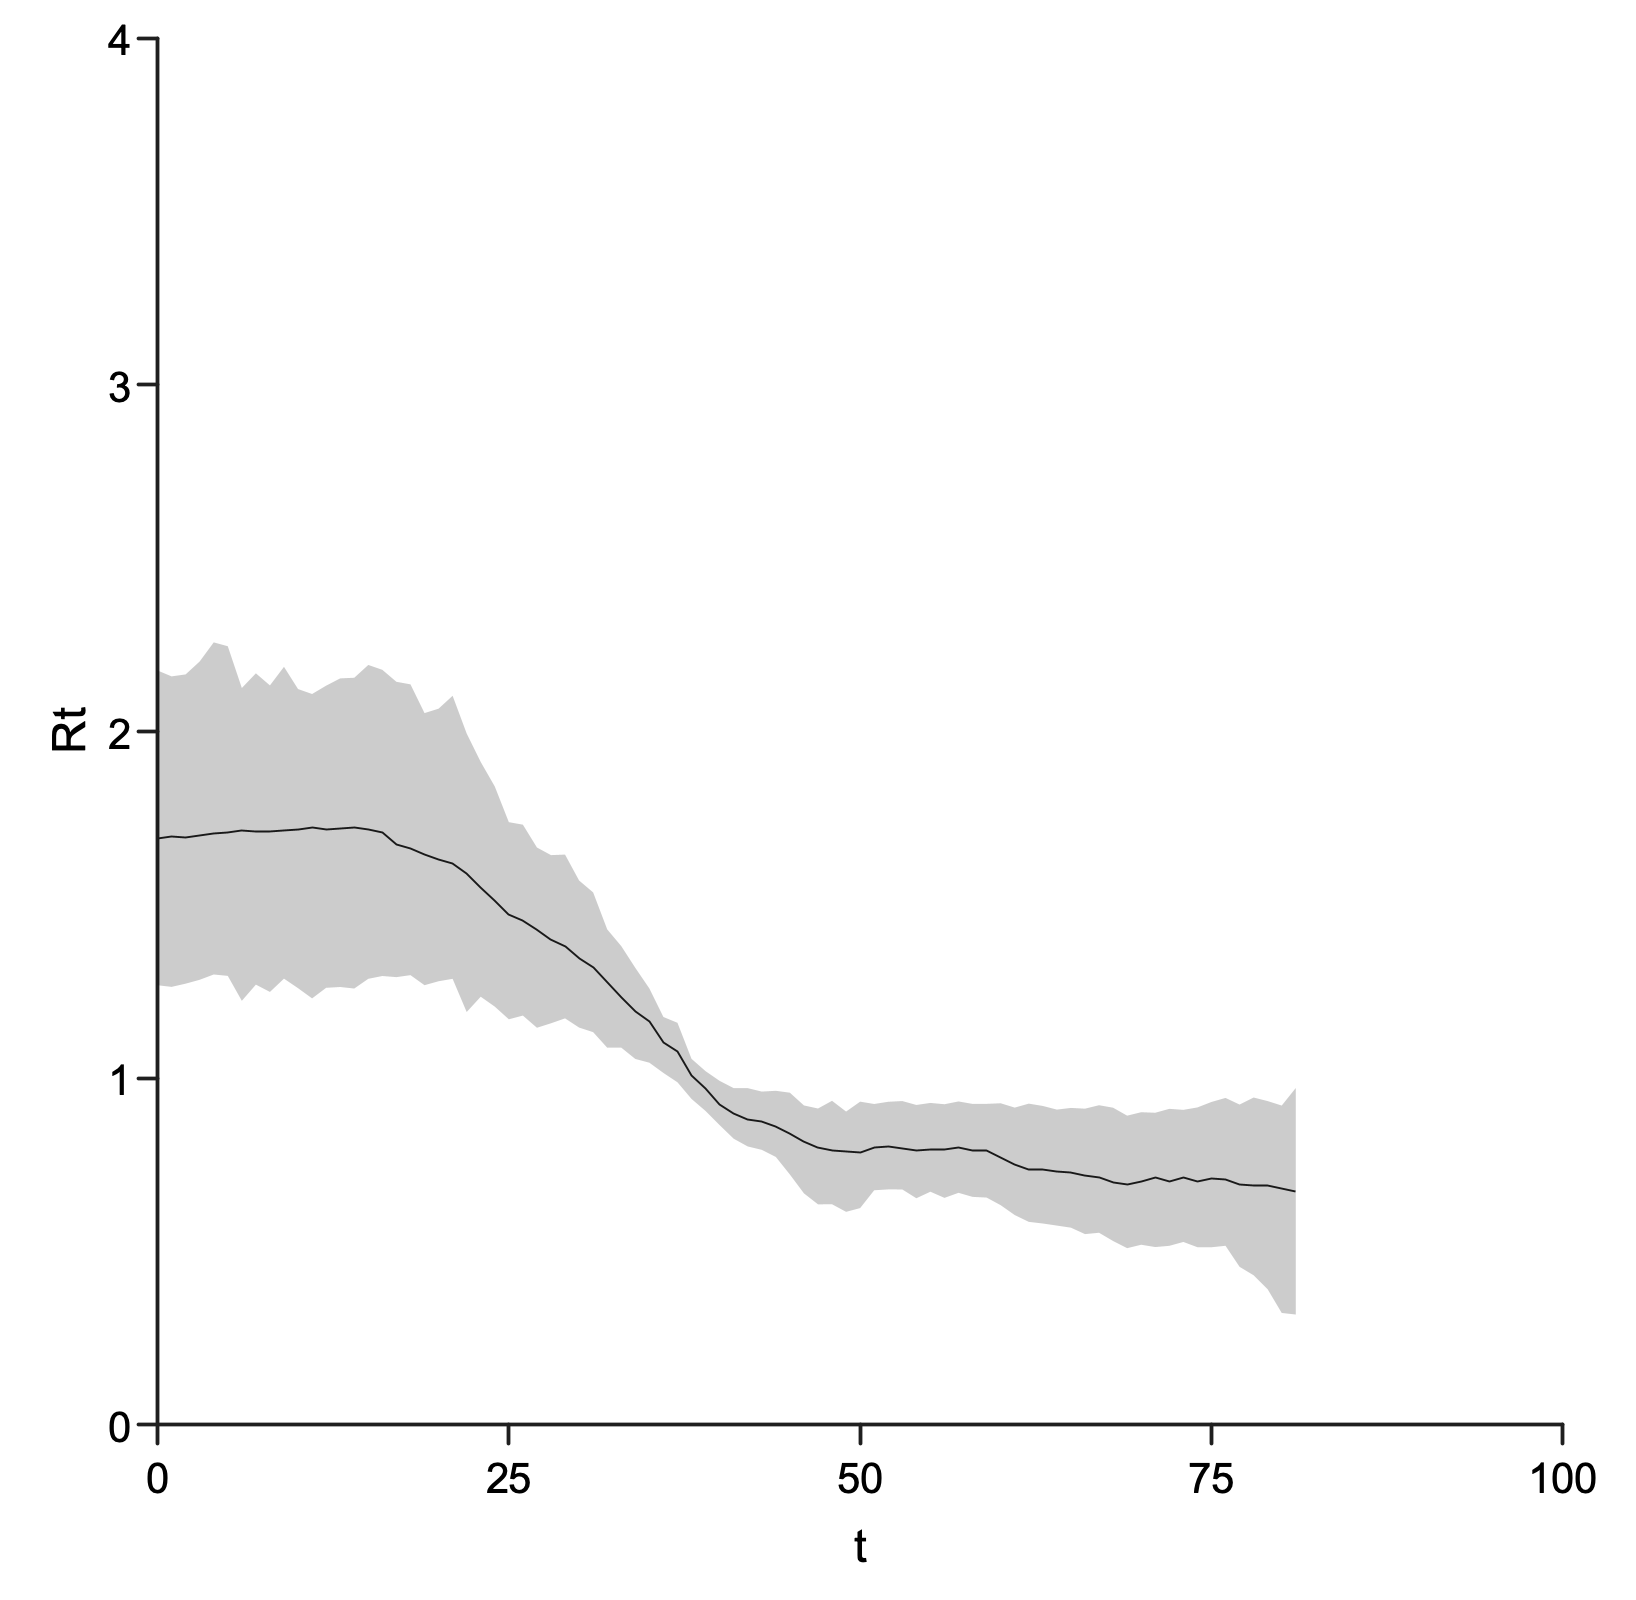

In [43]:
{{
    val countryName = "Spain"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates,_, _) = time { 
//         val res = predictRtOnset(onsetNumbers.dropRight(5).takeRight(60), pdelay)
        val res = predictRtOnset(onsetNumbers, pdelay, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

In [44]:
val countriesToPredict = countriesOnsetData.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [ ]:
val countryStats: Map[String, RtsDistributionStats] = {
    assert(countriesToPredict.toSet.subsetOf(countriesSmooth.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesSmooth.collect {
                case m if m("country") == countryName => m("cases").toLong
            }
            val (rts,estimates) = predictRt(caseNumbers)
            val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
            println(s"$countryName [done]")
            countryName -> stats
        }.seq
    }
    allStats.toMap
}

In [57]:
import scala.util.Try

val countryStatsOnset: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
               val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = predictRtOnset(caseNumbers, pdelay, failedRunDetection = false)
               val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
               println(s"$countryName [done]")
               stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (34ms) Acceptance rate: 0.87 E-BFMI: 0.74 Step size: 0.004 Total gradient evaluations: 2e+05 (151us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.69 E-BFMI: 0.71 Step size: 0.01 Total gradient evaluations: 2e+05 (242us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.80 E-BFMI: 0.59 Step size: 0.02 Total gradient evaluations: 2e+05 (188us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.88 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (216us) Total time: 0: 1: 0

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.82 E-BFMI: 0.62 Step size: 0.04 Total gradient evaluations: 2e+05 (143us) Total time: 0: 1: 0

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.86 E-BFMI: 0.75 Step size: 0.02 Total gradient evaluations: 2e+05 (219us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.81 E-BFMI: 0.75 Step size: 0.04 Total gradient evaluations: 2e+05 (133us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.80 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (194us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.73 E-BFMI: 0.63 Step size: 0.007 Total gradient evaluations: 2e+05 (135us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.83 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (264us) Total time: 0: 1: 1

Chain 1 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (123us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.76 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (152us) Total time: 0: 1: 0

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.85 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (130us) Total time: 0: 1: 1

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.77 E-BFMI: 0.75 Step size: 0.03 Total gradient evaluations: 2e+05 (136us) Total time: 0: 1: 0

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.80 E-BFMI: 0.63 Step size: 0.04 Total gradient evaluations: 2e+05 (169us) Total time: 0: 1: 0

Chain 1 Complete : Iteration: 1000 (33ms) Acceptance rate: 0.79 E-BFMI: 0.69 Step size: 0.04 Total gradient evaluations: 2e+05 (152us) Total time: 0: 1: 1

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.80 E-BFMI: 0.73 Step size: 0.02 Total gradient evaluations: 2e+05 (142us) Total time: 0: 1: 4

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.71 E-BFMI: 0.73 Step size: 0.007 Total gradient evaluations: 2e+05 (162us) Total time: 0: 1: 5

Chain 2 Complete : Iteration: 1000 (34ms) Acceptance rate: 0.91 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (139us) Total time: 0: 1: 6

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.75 E-BFMI: 0.77 Step size: 0.01 Total gradient evaluations: 2e+05 (165us) Total time: 0: 1: 5

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.73 E-BFMI: 0.65 Step size: 0.05 Total gradient evaluations: 2e+05 (255us) Total time: 0: 1: 6

Chain 2 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.004 Total gradient evaluations: 2e+05 (121us) Total time: 0: 1: 5

Chain 2 Complete : Iteration: 1000 (34ms) Acceptance rate: 0.75 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (125us) Total time: 0: 1: 5

Chain 2 Complete : Iteration: 1000 (41ms) Acceptance rate: 0.72 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (193us) Total time: 0: 1: 7

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.80 E-BFMI: 0.69 Step size: 0.04 Total gradient evaluations: 2e+05 (200us) Total time: 0: 1: 6

Chain 2 Complete : Iteration: 1000 (41ms) Acceptance rate: 0.78 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (332us) Total time: 0: 1: 6

Chain 2 Complete : Iteration: 1000 (44ms) Acceptance rate: 0.84 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (168us) Total time: 0: 1: 8

Chain 2 Complete : Iteration: 1000 (42ms) Acceptance rate: 0.79 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (210us) Total time: 0: 1: 8

Chain 2 Complete : Iteration: 1000 (44ms) Acceptance rate: 0.87 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (139us) Total time: 0: 1: 8

Chain 2 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.85 E-BFMI: 0.77 Step size: 0.02 Total gradient evaluations: 2e+05 (213us) Total time: 0: 1: 8

Chain 2 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.87 E-BFMI: 0.67 Step size: 0.02 Total gradient evaluations: 2e+05 (133us) Total time: 0: 1: 7

Chain 2 Complete : Iteration: 1000 (43ms) Acceptance rate: 0.82 E-BFMI: 0.72 Step size: 0.04 Total gradient evaluations: 2e+05 (127us) Total time: 0: 1: 7

Sweden [done]


Chain 1 Complete : Iteration: 1000 (25ms) Acceptance rate: 0.84 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (112us) Total time: 56s

Netherlands [done]
Russia [done]
Spain [done]
Austria [done]
Belarus [done]


Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.88 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (118us) Total time: 57s

Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.80 E-BFMI: 0.57 Step size: 0.04 Total gradient evaluations: 2e+05 (110us) Total time: 57s

Malta [done]


Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.82 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (187us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.85 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 2e+05 (126us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (28ms) Acceptance rate: 0.78 E-BFMI: 0.71 Step size: 0.004 Total gradient evaluations: 2e+05 (130us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.79 E-BFMI: 0.78 Step size: 0.04 Total gradient evaluations: 2e+05 (118us) Total time: 58s

Slovakia [done]
Romania [done]
Greece [done]


Chain 1 Complete : Iteration: 1000 (29ms) Acceptance rate: 0.85 E-BFMI: 0.62 Step size: 0.02 Total gradient evaluations: 2e+05 (127us) Total time: 57s

Ireland [done]
Finland [done]
Hungary [done]
Estonia [done]
Czechia [done]
Poland [done]


Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.88 E-BFMI: 0.58 Step size: 0.004 Total gradient evaluations: 2e+05 (174us) Total time: 55s

Chain 1 Complete : Iteration: 1000 (29ms) Acceptance rate: 0.90 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (163us) Total time: 57s

Chain 1 Complete : Iteration: 1000 (28ms) Acceptance rate: 0.77 E-BFMI: 0.66 Step size: 0.04 Total gradient evaluations: 2e+05 (163us) Total time: 59s

Chain 1 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.80 E-BFMI: 0.74 Step size: 0.005 Total gradient evaluations: 2e+05 (112us) Total time: 57s

Chain 1 Complete : Iteration: 1000 (28ms) Acceptance rate: 0.79 E-BFMI: 0.58 Step size: 0.03 Total gradient evaluations: 2e+05 (116us) Total time: 58s

Chain 1 Complete : Iteration: 1000 (28ms) Acceptance rate: 0.81 E-BFMI: 0.72 Step size: 0.04 Total gradient evaluations: 2e+05 (125us) Total time: 58s

Chain 2 Complete : Iteration: 1000 (26ms) Acceptance rate: 0.78 E-BFMI: 0.75 Step size: 0.04 Total gradient evaluations: 2e+05 (138us) Total time: 53s

Chain 2 Complete : Iteration: 1000 (25ms) Acceptance rate: 0.79 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (128us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (26ms) Acceptance rate: 0.82 E-BFMI: 0.60 Step size: 0.04 Total gradient evaluations: 2e+05 (144us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.82 E-BFMI: 0.58 Step size: 0.04 Total gradient evaluations: 2e+05 (139us) Total time: 57s

Chain 2 Complete : Iteration: 1000 (27ms) Acceptance rate: 0.87 E-BFMI: 0.83 Step size: 0.01 Total gradient evaluations: 2e+05 (144us) Total time: 56s

Chain 2 Complete : Iteration: 1000 (26ms) Acceptance rate: 0.77 E-BFMI: 0.60 Step size: 0.04 Total gradient evaluations: 2e+05 (102us) Total time: 57s

Chain 2 Complete : Iteration: 1000 (24ms) Acceptance rate: 0.95 E-BFMI: 0.55 Step size: 0.004 Total gradient evaluations: 2e+05 (79us) Total time: 57s

Chain 2 Complete : Iteration: 1000 (26ms) Acceptance rate: 0.89 E-BFMI: 0.52 Step size: 0.004 Total gradient evaluations: 2e+05 (138us) Total time: 54s

Chain 2 Complete : Iteration: 1000 (24ms) Acceptance rate: 0.85 E-BFMI: 0.60 Step size: 0.02 Total gradient evaluations: 2e+05 (95us) Total time: 56s

Chain 2 Complete : Iteration: 1000 (23ms) Acceptance rate: 0.79 E-BFMI: 0.61 Step size: 0.005 Total gradient evaluations: 2e+05 (94us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (22ms) Acceptance rate: 0.90 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 2e+05 (71us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (21ms) Acceptance rate: 0.83 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (70us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (20ms) Acceptance rate: 0.78 E-BFMI: 0.62 Step size: 0.04 Total gradient evaluations: 2e+05 (72us) Total time: 55s

Chain 2 Complete : Iteration: 1000 (18ms) Acceptance rate: 0.81 E-BFMI: 0.63 Step size: 0.04 Total gradient evaluations: 2e+05 (69us) Total time: 55s

Lithuania [done]
Bulgaria [done]
Croatia [done]


Chain 1 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (51us) Total time: 25s

Italy [done]
Belgium [done]
Luxembourg [done]
Slovenia [done]
United_Kingdom [done]
Switzerland [done]
Germany [done]
Portugal [done]
Denmark [done]
Cyprus [done]
Latvia [done]


Chain 2 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.79 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 2e+05 (53us) Total time: 21s

Norway [done]


Chain 1 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.70 E-BFMI: 0.78 Step size: 0.006 Total gradient evaluations: 2e+05 (50us) Total time: 21s

Chain 2 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.86 E-BFMI: 0.62 Step size: 0.006 Total gradient evaluations: 2e+05 (53us) Total time: 21s

France [done]
Elapsed time: 333917 ms


import scala.util.Try


countryStatsOnset: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.4337899065626927),
        (1, 1.4336867607866204),
        (2, 1.433016672627332),
        (3, 1.434588706629662),
        (4, 1.43540322483966),
        (5, 1.4376859917421654),
        (6, 1.4411613699071735),
        (7, 1.442181103453762),
        (8, 1.4414687264228079),
        (9, 1.442447320404932),
        (10, 1.4427223990158187),
        (11, 1.4421394951839408),
        (12, 1.4460127565526257),
        (13, 1.4461547971016666),
        (14, 1.4444464449473613),
        (15, 1.4454571239709428),
        (16, 1.4453389107669472),
        (17, 1.4430127294056416),
        (18, 1.4406159115087926),
        (19, 1.4363764732180473),
        (20, 1.4337471996638478),
        (21, 1.4290912393417872),
        (22, 1.4204624265602204),
        (23, 1.415042864940889),
        (24, 1.4069557883725525),
   

In [58]:
val failedToConverge = countryStatsOnset collect {
    case (countryName, res) if res.isLeft => countryName
}

failedToConverge: collection.immutable.Iterable[String] = List()

In [ ]:
{{
    val countryName = "France"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRtOnset(onsetNumbers, pdelay, 60, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
//     show("serialInterval", density(serialEstimates))
}}

In [ ]:
// co
val countriesTriedOneMoreTime = failedToConverge.toSeq.diff(Seq("Lithuania")) map { countryName =>
    println(countryName)
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRtOnset(onsetNumbers.takeRight(50), pdelay, failedRunDetection = false)
        res
    }
    countryName -> distributionStats(rts, estimates)
}

In [59]:
val finalCountryStatsOnset = (countryStatsOnset collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

finalCountryStatsOnset: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4337899065626927),
      (1, 1.4336867607866204),
      (2, 1.433016672627332),
      (3, 1.434588706629662),
      (4, 1.43540322483966),
      (5, 1.4376859917421654),
      (6, 1.4411613699071735),
      (7, 1.442181103453762),
      (8, 1.4414687264228079),
      (9, 1.442447320404932),
      (10, 1.4427223990158187),
      (11, 1.4421394951839408),
      (12, 1.4460127565526257),
      (13, 1.4461547971016666),
      (14, 1.4444464449473613),
      (15, 1.4454571239709428),
      (16, 1.4453389107669472),
      (17, 1.4430127294056416),
      (18, 1.4406159115087926),
      (19, 1.4363764732180473),
      (20, 1.4337471996638478),
      (21, 1.4290912393417872),
      (22, 1.4204624265602204),
      (23, 1.415042864940889),
      (24, 1.4069557883725525),
      (25, 1.397059475357083),
      (26, 1.3874201383217126),
      (27, 1.3782293444841867),
      (28

In [60]:
// override the previous variable so the rest of the notebook works fine
val countryStatsOnset = finalCountryStatsOnset

countryStatsOnset: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4337899065626927),
      (1, 1.4336867607866204),
      (2, 1.433016672627332),
      (3, 1.434588706629662),
      (4, 1.43540322483966),
      (5, 1.4376859917421654),
      (6, 1.4411613699071735),
      (7, 1.442181103453762),
      (8, 1.4414687264228079),
      (9, 1.442447320404932),
      (10, 1.4427223990158187),
      (11, 1.4421394951839408),
      (12, 1.4460127565526257),
      (13, 1.4461547971016666),
      (14, 1.4444464449473613),
      (15, 1.4454571239709428),
      (16, 1.4453389107669472),
      (17, 1.4430127294056416),
      (18, 1.4406159115087926),
      (19, 1.4363764732180473),
      (20, 1.4337471996638478),
      (21, 1.4290912393417872),
      (22, 1.4204624265602204),
      (23, 1.415042864940889),
      (24, 1.4069557883725525),
      (25, 1.397059475357083),
      (26, 1.3874201383217126),
      (27, 1.3782293444841867),
      (28, 1.3

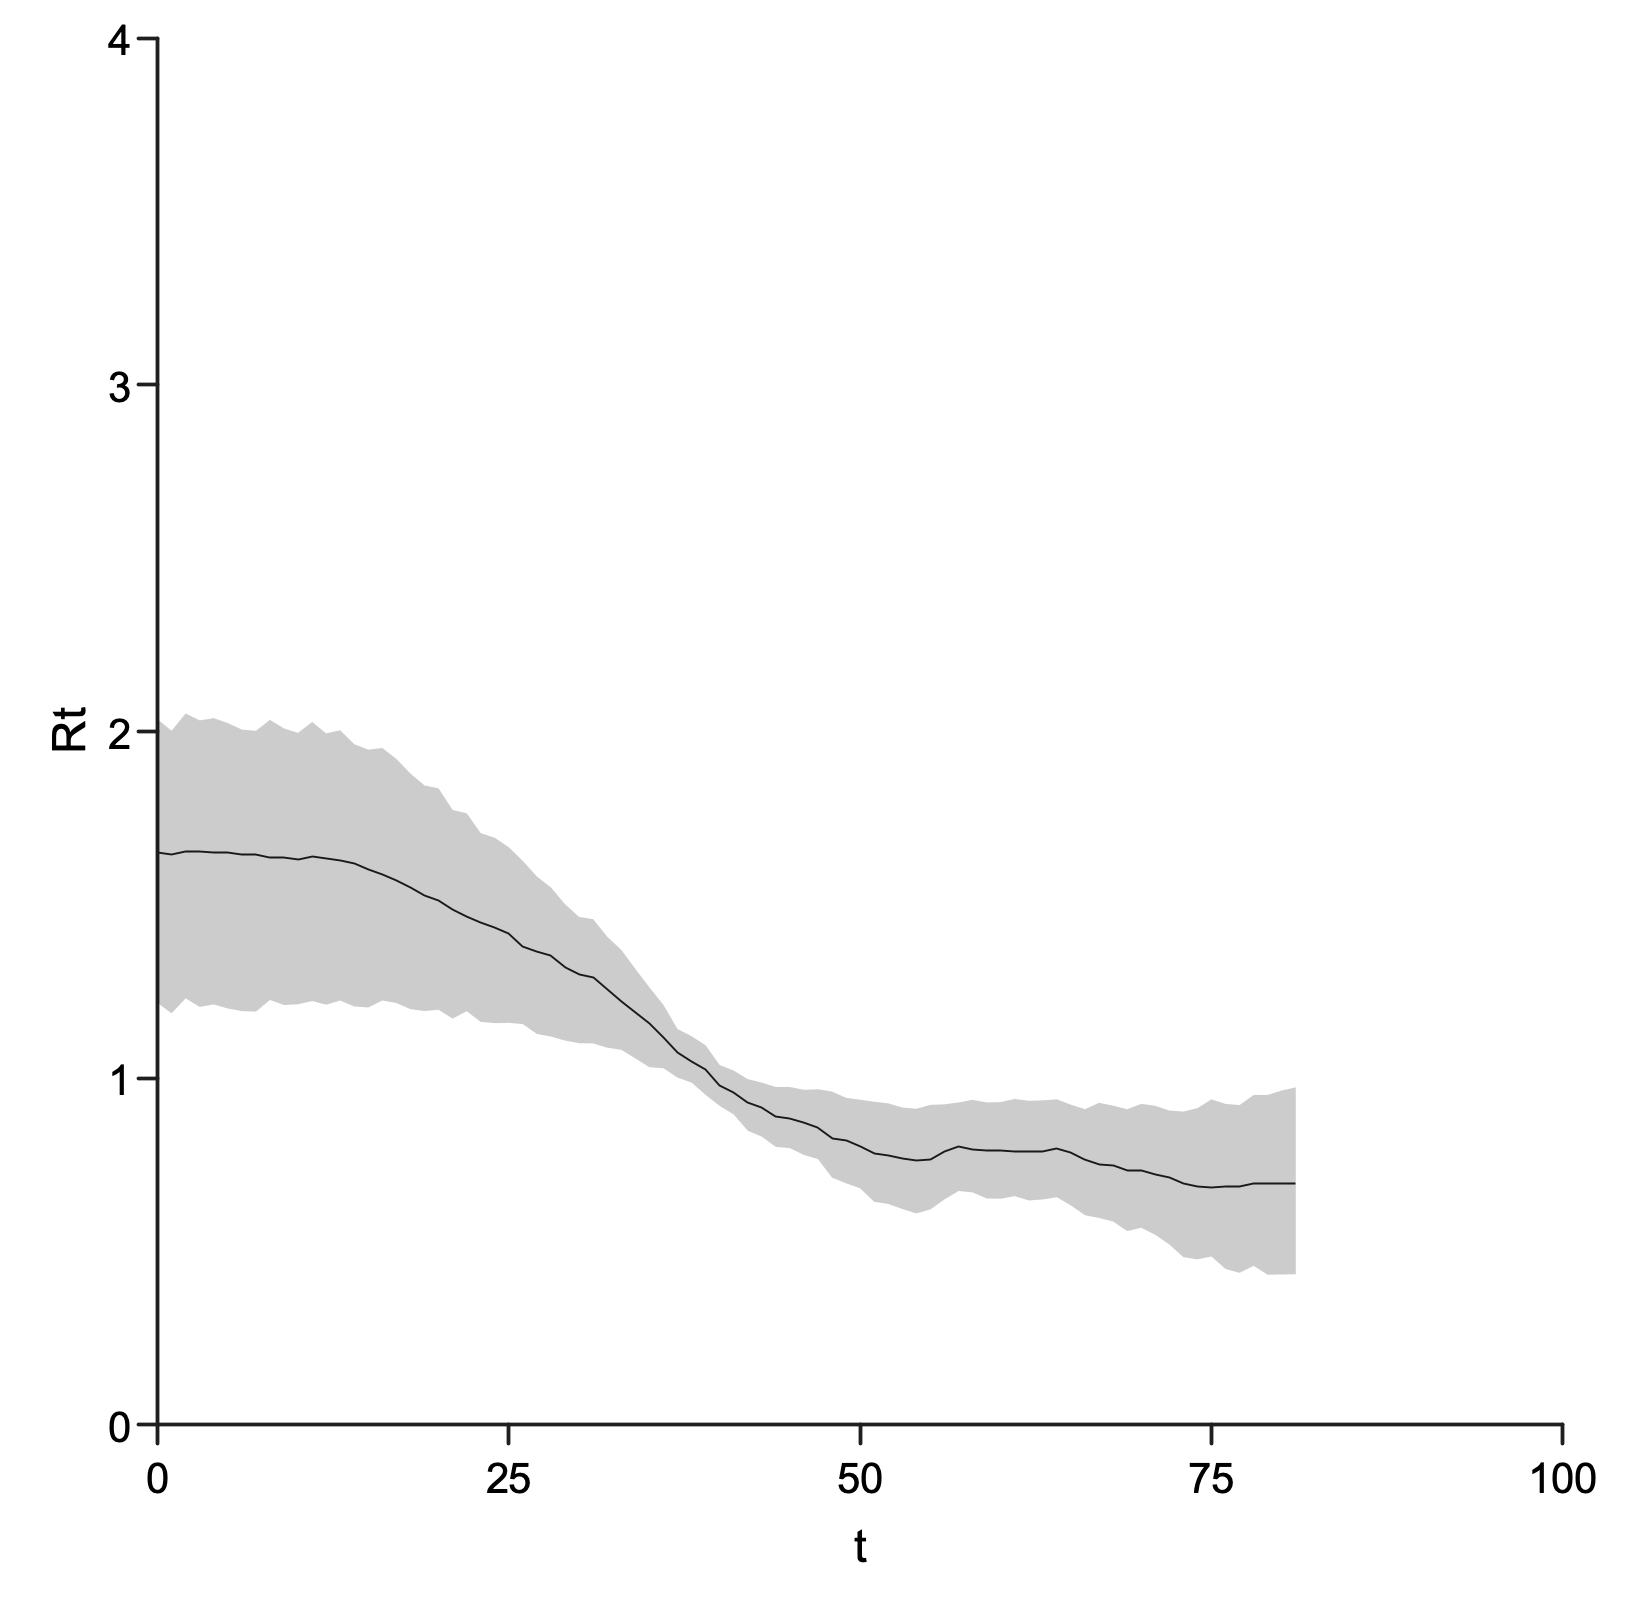

In [63]:
{{
    val RtsDistributionStats(means, hdpis) = countryStatsOnset("France")
    //  val RtsDistributionStats(means, hdpis) = countryStats("Austria")
    show("t", "Rt", line(means), shade(hdpis))
}}

In [64]:
def datesForCountry(country: String) = {
    /* countriesSmooth.collect {
        case m if m("country") == country => m("date")
    }*/
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [69]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [70]:
val csvWriter = CSVWriter.open(new File("data/rt-rainierOnset.csv")) // rt-rainier.csv

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@525a5f38

In [71]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [72]:
// countryStats.toList.sortBy(_._1).foreach {
countryStatsOnset.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [73]:
csvWriter.close()

Changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a Laplace transition to strongly regularize
* put a prior on the std dev of the transition, rather than fixing it
* put a prior on the serial interval rather than fixing it

In [ ]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val serialInterval = Normal(5,2).latent
    val logR0 = Normal(0, 1).latent
    val sigma = Exponential(10).latent
    val diffs = Laplace(0,sigma).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [ ]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

In [ ]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}

In [ ]:
rts